In [1]:
import geopandas as gpd
from udtk import geo, viz
import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline

/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
#load original data
carto = gpd.read_file('../carto/nyc_parcels.geojson')

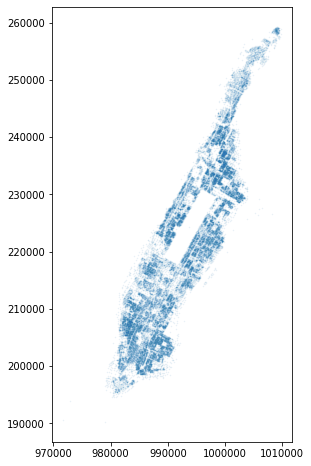

In [3]:
#plot original parcel data
f,ax = plt.subplots(figsize=(8,8))
carto.plot(ax=ax, alpha=0.1,markersize=0.2)

In [4]:
#create grid a simple grid using H3 with a resolution level of 8 
grid_8 = geo.hexgrid_from_shapefile(input_shapefile='../carto/nyc_parcels.geojson',
                                  output_shapefile='../carto/grid_8',
                                  res = 8)

#create grid a simple grid using H3 with a resolution level of 8 
grid_10 = geo.hexgrid_from_shapefile(input_shapefile='../carto/nyc_parcels.geojson',
                                  res = 10)

In [5]:
#final table
grid_8.head()

,h3_res_8,n,geometry
0,882a10085bfffff,2,"POLYGON ((-8231979.536 4991102.167, -8232691.3..."
1,882a100881fffff,290,"POLYGON ((-8234612.577 4983222.344, -8235323.5..."
2,882a100883fffff,962,"POLYGON ((-8234340.000 4982064.997, -8235050.8..."
3,882a100887fffff,102,"POLYGON ((-8235542.610 4982411.218, -8236253.4..."
4,882a100889fffff,533,"POLYGON ((-8233682.332 4984033.499, -8234393.3..."


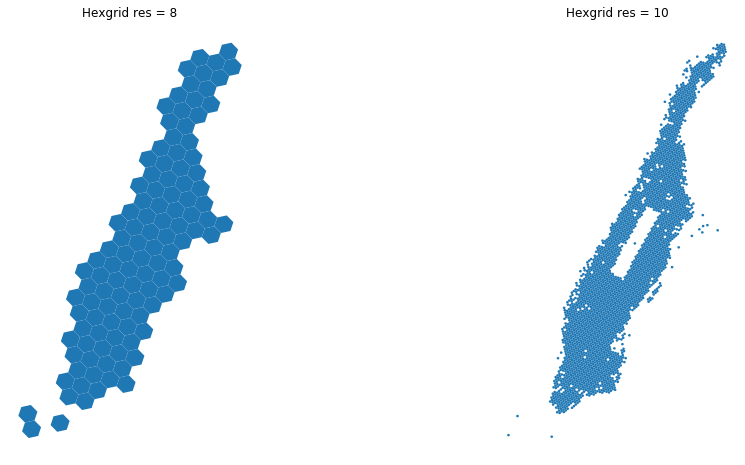

In [6]:
#plot hexgrid data
f,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
grid_8.plot(ax=ax1)
grid_10.plot(ax=ax2)
ax1.set_title('Hexgrid res = 8')
ax2.set_title('Hexgrid res = 10')
ax1.set_axis_off()
ax2.set_axis_off();

In [7]:
#create a weights matrix based that grid using Queen contiguity
w = geo.weights_matrix(grid_id_name = 'h3_res_8',
                       input_shapefile = '../carto/grid_8/grid_8.shp',
                      output_pickle = '../data/w_8.pickle')

/home/pipe/urbansim/udtk/venv/lib/python3.7/site-packages/pysal-2.1.0-py3.7.egg/pysal/lib/weights/contiguity.py:185: UserWarning:

There is one disconnected observation (no neighbors).
Island id: 882a1072b9fffff



In [8]:
#look at weights for a given cell id
cell_id = '882a100883fffff'
w[cell_id]

{'882a100881fffff': 1.0,
 '882a10088bfffff': 1.0,
 '882a100887fffff': 1.0,
 '882a10089dfffff': 1.0,
 '882a100895fffff': 1.0,
 '882a1008b9fffff': 1.0}

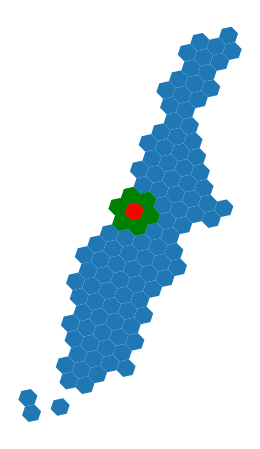

In [9]:
#plot the cell and the contiguous cells based on Queen distance
f,ax = plt.subplots(figsize=(8,8))
grid_8.plot(ax=ax)
grid_8.loc[grid_8.h3_res_8 == cell_id].plot(ax=ax,color='red')
grid_8.loc[grid_8.h3_res_8.isin(w[cell_id].keys())].plot(ax=ax,color='green')
ax.set_axis_off()

# Use H3 to aggregate data to several levels of resolution

In [10]:
carto_latlon = carto.to_crs(epsg=4326)
carto_latlon['lon'] = carto_latlon.geometry.x
carto_latlon['lat'] = carto_latlon.geometry.y

In [11]:
resolutions =  [8,9,10,11]
aggregation_dict = {'RetailArea':'mean','NumBldgs':'sum'}
aggregation_cols = ['h3_res_'+str(res) for res in resolutions ]

In [12]:
%time carto_latlon = geo.h3_indexing(carto_latlon.copy(), res = resolutions,x_col='lon', y_col='lat')

CPU times: user 4.96 s, sys: 23.7 ms, total: 4.99 s
Wall time: 4.99 s


In [13]:
#show dataframe with the original geometry and the h3 cells they fall within at several resolution levels
carto_latlon.loc[:5,['BBL','RetailArea','geometry']+aggregation_cols]

,BBL,RetailArea,geometry,h3_res_8,h3_res_9,h3_res_10,h3_res_11
0,1.020730e+09,0,POINT (-73.95089 40.82354),882a1008c9fffff,892a1008c93ffff,8a2a1008c827fff,8b2a1008c824fff
1,1.020890e+09,2000,POINT (-73.95203 40.82492),882a1008c9fffff,892a1008c93ffff,8a2a1008c917fff,8b2a1008c913fff
2,1.020990e+09,0,POINT (-73.94859 40.83167),882a100aa1fffff,892a100aa0fffff,8a2a100aa0cffff,8b2a100aa0cafff
3,1.021090e+09,0,POINT (-73.93964 40.83473),882a100aabfffff,892a100aaabffff,8a2a100aaab7fff,8b2a100aaab4fff
4,1.021090e+09,0,POINT (-73.93936 40.83480),882a100aabfffff,892a100aabbffff,8a2a100aab9ffff,8b2a100aab9bfff
5,1.021200e+09,0,POINT (-73.94176 40.83625),882a100aa1fffff,892a100aa17ffff,8a2a100aa147fff,8b2a100aa144fff


In [14]:
#aggregate data at cell level for different resolutions
%time gdf_list = [geo.aggregate_h3(carto_latlon,aggregation_col,aggregation_dict) for aggregation_col in aggregation_cols]

IndentationError: unexpected indent (<ipython-input-14-5a4e368d9c26>, line 3)

In [ ]:
#plot the results
[viz.plot_h3_gdf(h3_gdf = gdf_list[i],
                 plot_column = 'RetailArea',
                scheme = 'Quantiles',
                k=3) for i in range(len(gdf_list))]
                            
                            
                            

In [ ]:
h3_aggregated_8 = geo.aggregate_h3(carto_latlon,'h3_res_8',aggregation_dict)
h3_aggregated_8.to_file('../carto/h3_aggregated_8.geojson',driver='GeoJSON')

In [ ]:
viz.plotly_viz(dt,'RetailArea')